<h1 align="center"><font color='#4169E1'>Explainability techniques for Images :</font> <font color='#D23B68'>Integrated Gradients</font></h1>

### <font color='#D23B68'>Table of contents<font><a class='anchor' id='top'></a>
- [Necessary imports](#0)
- [Loading the model](#1)
- [Creating a baseline](#2)
- [Creating the straightline from the baseline to the actual image](#3)
- [Computing the gradients](#4)
- [Riemann Approximation for calculating integrals](#5)
- [Implementation of Integrated Gradients](#6)
- [Testing the method](#7)

<a id='0'></a>
<h1><font color='#4169E1'>Imports</font></h1>

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

<a id='1'></a>
<h1><font color='#4169E1'>Loading the model</font></h1>

<h2><font color='#D23B68'>Loading the model's weights : Inception for ImageNet</font></h2>

In [3]:
model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1',
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4',
        trainable=False),
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v1 (KerasLayer)   (None, 1001)              6633209   
                                                                 
Total params: 6633209 (25.30 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 6633209 (25.30 MB)
_________________________________________________________________


<h2><font color='#D23B68'>Loading ImageNet's labels</font></h2>

In [4]:
file_path = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)

with open(labels_file) as reader:
    f = reader.read()
    labels = f.splitlines()
    imagenet_labels =  np.array(labels)

10484/10484 [==============================] - 0s 0us/step


<h2><font color='#D23B68'>Using the model to predict the class of an image</font></h2>

In [5]:
def read_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

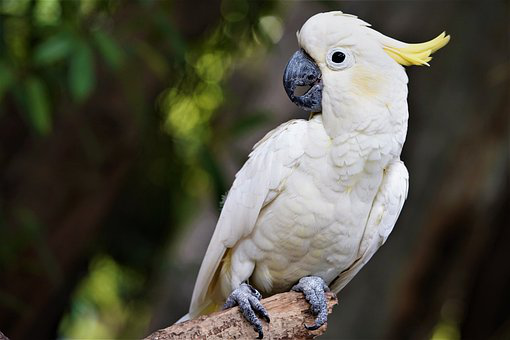

In [6]:
img_path = './cockatoo.png'
tf.keras.utils.load_img(img_path, grayscale=False)

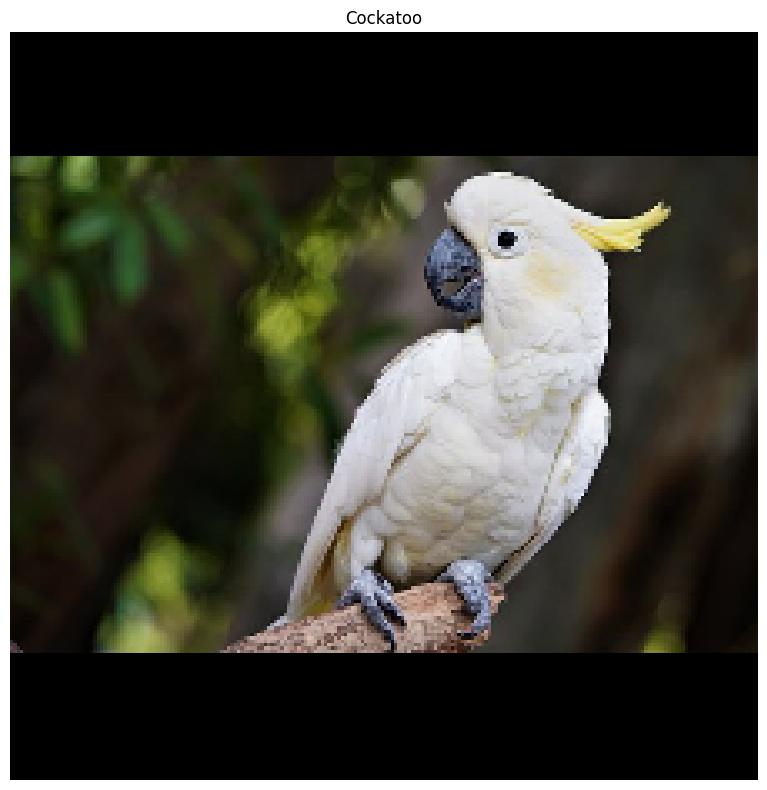

In [11]:
image_tensor = read_image(img_path)
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)
ax.imshow(image_tensor)
ax.set_title('Cockatoo')
ax.axis('off')
plt.tight_layout()

In [9]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    predictions = model(image_batch)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

In [10]:
pred_label, pred_prob = top_k_predictions(image_tensor)
for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

sulphur-crested cockatoo: 99.6%
spoonbill: 0.1%
American egret: 0.0%


<a id='2'></a>
<h1><font color='#4169E1'>Creating a baseline : a black image</font></h1>

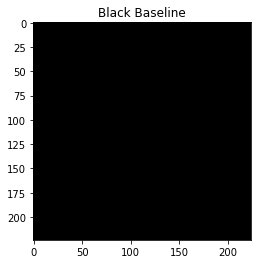

In [51]:
black_baseline = tf.zeros(shape=(224,224,3))
plt.imshow(black_baseline)
plt.title("Black Baseline")
plt.axis('on')
plt.show()

<a id='3'></a>
<h1><font color='#4169E1'>Creating the straightline (from baseline to actual image)</font></h1>

In [65]:
def interpolate_images(baseline,
                       image,
                       alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    images = alphas_x * input_x + (1 - alphas_x) * baseline_x
    return images

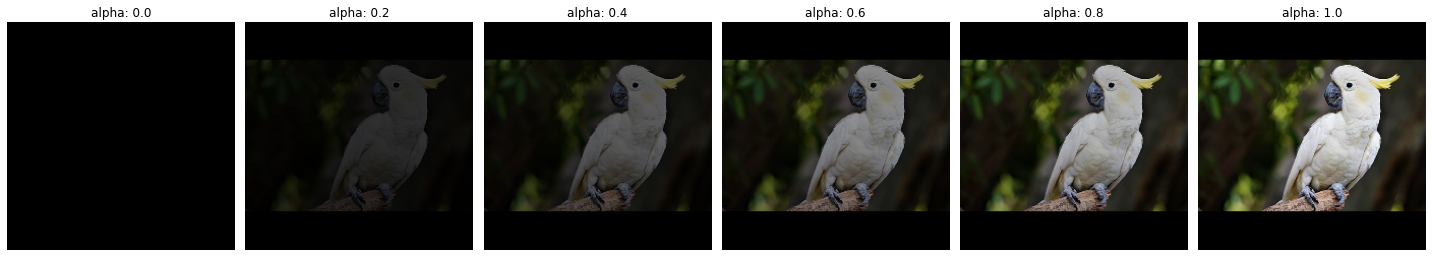

In [66]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
interpolated_images = interpolate_images(black_baseline,
                                         image_tensor,
                                         alphas)

fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

<a id='4'></a>
<h1><font color='#4169E1'>Computing the gradients</font></h1>

In [67]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

<a id='5'></a>
<h1><font color='#4169E1'>Riemann Approximation for calculating the integral</font></h1>

In [43]:
def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

<a id='6'></a>
<h1><font color='#4169E1'>Integrated Gradients</font></h1>

In [79]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
	gradient_batches = []

  
    for alpha in tf.range(0, len(alphas), batch_size):
        from_ = alpha
        to = tf.minimum(from_ + batch_size, len(alphas))
        alpha_batch = alphas[from_:to]

        gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
        gradient_batches.append(gradient_batch)

    total_gradients = tf.concat(gradient_batches, axis=0)

    avg_gradients = integral_approximation(gradients=total_gradients)

    integrated_gradients = (image - baseline) * avg_gradients

    return integrated_gradients

<a id='7'></a>
<h1><font color='#4169E1'>Testing the method</font></h1>

In [80]:
def one_batch(baseline, image, alpha_batch, target_class_idx):
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

In [82]:
ig_attributions = integrated_gradients(baseline=black_baseline,
                                       image=image_tensor,
                                       target_class_idx=90,
                                       m_steps=240)

In [83]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

    attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

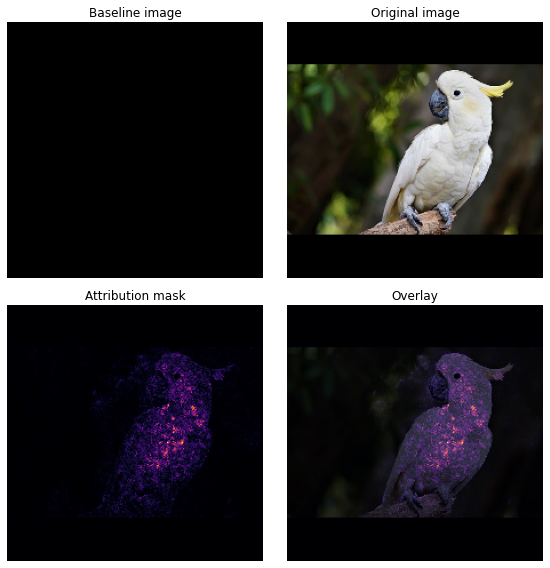

In [84]:
_ = plot_img_attributions(image=image_tensor,
                          baseline=black_baseline,
                          target_class_idx=90,
                          m_steps=50,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.2)